In [ ]:
import requests
import json

def get_iterate(endpoint, b64_creds, objectname, api_key):
    initial_url = 'https://api.netilion.endress.com/v1' + endpoint
    auth_hdr = "Basic: " + b64_creds
    
    headers_get={'Accept': 'application/json', 'Api-key': api_key, 'Authorization': auth_hdr}
    response_get = requests.get(initial_url, headers=headers_get, verify=True)

    if response_get.status_code == 200:
        response_get_json = response_get.json()
        data = []
        for obj in response_get_json[objectname]:
            data.append(obj)
        if 'next' in response_get_json['pagination']:
            next_url = response_get_json['pagination']['next']
            while 'next' in response_get_json['pagination']:
                response_get = requests.get(next_url, headers=headers_get, verify=True)
                response_get_json = response_get.json()
                for obj in response_get_json[objectname]:
                    data.append(obj)
                if 'next' in response_get_json['pagination']:
                    next_url = response_get_json['pagination']['next']
        return data
    else:
        data = [{"msg":"Error","status_code": response_get.status_code}]
        return data

values_json = get_iterate('/instrumentations/123/values/PV','b64_credentials','data','api-key')
#print(values_json)

In [2]:
import pandas as pd
from pandas import to_datetime

%matplotlib inline
from matplotlib import pyplot

df = pd.DataFrame()
df = df.append(values_json)
df.head()

,timestamp,value
0,2021-04-29T16:45:03Z,98.524983
1,2021-04-29T16:52:34Z,96.440881
2,2021-04-29T17:00:04Z,98.300324
3,2021-04-29T17:07:35Z,96.694324
4,2021-04-29T17:15:05Z,96.677171


In [3]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
df = df.set_index('Datetime')
df.head()

,timestamp,value
Datetime,,
2021-04-29 16:45:03+00:00,2021-04-29T16:45:03Z,98.524983
2021-04-29 16:52:34+00:00,2021-04-29T16:52:34Z,96.440881
2021-04-29 17:00:04+00:00,2021-04-29T17:00:04Z,98.300324
2021-04-29 17:07:35+00:00,2021-04-29T17:07:35Z,96.694324
2021-04-29 17:15:05+00:00,2021-04-29T17:15:05Z,96.677171


In [5]:
df = df.resample('10T').fillna("nearest")
df.head()

,timestamp,value
Datetime,,
2021-04-29 16:40:00+00:00,2021-04-29T16:45:03Z,98.524983
2021-04-29 16:50:00+00:00,2021-04-29T16:52:34Z,96.440881
2021-04-29 17:00:00+00:00,2021-04-29T17:00:04Z,98.300324
2021-04-29 17:10:00+00:00,2021-04-29T17:07:35Z,96.694324
2021-04-29 17:20:00+00:00,2021-04-29T17:22:36Z,97.007416


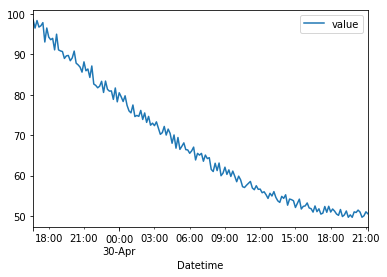

In [6]:
df.plot()

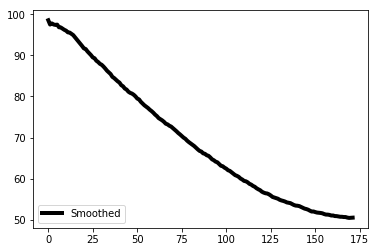

In [7]:
df['Ticks'] = range(0,len(df.index.values))
df = df.reset_index()
df['rolling_mean'] = df['value'].rolling(window = 15, min_periods=1).mean()
fig = pyplot.figure();
ax = fig.add_subplot(111);
ax.plot(df.index,df['rolling_mean'], color = (0,0,0), linewidth = 4, label = 'Smoothed');
ax.legend(loc='lower left');

In [8]:
df.head()

,Datetime,timestamp,value,Ticks,rolling_mean
0,2021-04-29 16:40:00+00:00,2021-04-29T16:45:03Z,98.524983,0,98.524983
1,2021-04-29 16:50:00+00:00,2021-04-29T16:52:34Z,96.440881,1,97.482932
2,2021-04-29 17:00:00+00:00,2021-04-29T17:00:04Z,98.300324,2,97.755396
3,2021-04-29 17:10:00+00:00,2021-04-29T17:07:35Z,96.694324,3,97.490128
4,2021-04-29 17:20:00+00:00,2021-04-29T17:22:36Z,97.007416,4,97.393586


In [12]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Ticks'].values.reshape(-1, 1), df['rolling_mean'].values.reshape(-1, 1),test_size=0.2)
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000
model_poly = make_pipeline(PolynomialFeatures(2, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
model_poly.fit(X_train,y_train)

#for reference: linear model as comparison
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression().fit(df['Ticks'].values.reshape(-1, 1),df['rolling_mean'].values.reshape(-1, 1))

C:\Users\i02401253\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
df['predictions_poly'] = model_poly.predict(df['Ticks'].values.reshape(-1,1))
df['predictions_linear'] = model_linear.predict(df['Ticks'].values.reshape(-1,1))

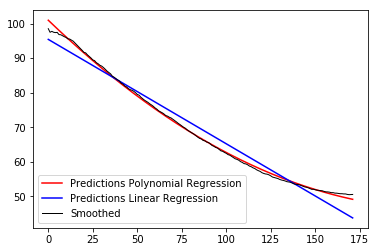

In [14]:
fig2 = pyplot.figure();
ax = fig2.add_subplot(111);
ax.plot(df.index,df['predictions_poly'], color = (1,0,0), label = 'Predictions Polynomial Regression');
ax.plot(df.index,df['predictions_linear'], color = (0,0,1), label = 'Predictions Linear Regression');
ax.plot(df.index,df['rolling_mean'], color = (0,0,0), linewidth = 1, label = 'Smoothed');
ax.legend(loc='lower left');

In [13]:
import numpy as np
test_pred = np.array(model_poly.predict(X_test))
test_score = model_poly.score(X_test,y_test)
print(test_score)

0.9987917216718784


In [18]:
import sklearn 

r_squared = sklearn.metrics.r2_score(df['rolling_mean'],df['predictions_poly'],multioutput='uniform_average')
r_squared

0.9983218090226977

In [15]:
counter = df.index.max()
df2 = pd.DataFrame(columns=['Ticks'])
for i in range(100):
    number = counter + i + 1
    df2 = df2.append({'Ticks': number}, ignore_index=True)
#df2
df3 = pd.merge(df, df2, on='Ticks', how='outer')
df3.reset_index()
#df3

,index,Datetime,timestamp,value,Ticks,rolling_mean,predictions_poly,predictions_linear
0,0,2021-04-29 16:40:00+00:00,2021-04-29T16:45:03Z,98.524983,0.0,98.524983,100.970101,95.426269
1,1,2021-04-29 16:50:00+00:00,2021-04-29T16:52:34Z,96.440881,1.0,97.482932,100.476145,95.124144
2,2,2021-04-29 17:00:00+00:00,2021-04-29T17:00:04Z,98.300324,2.0,97.755396,99.984436,94.822018
3,3,2021-04-29 17:10:00+00:00,2021-04-29T17:07:35Z,96.694324,3.0,97.490128,99.494972,94.519893
4,4,2021-04-29 17:20:00+00:00,2021-04-29T17:22:36Z,97.007416,4.0,97.393586,99.007754,94.217767
...,...,...,...,...,...,...,...,...
267,267,NaT,NaN,NaN,267.0,NaN,NaN,NaN
268,268,NaT,NaN,NaN,268.0,NaN,NaN,NaN
269,269,NaT,NaN,NaN,269.0,NaN,NaN,NaN
270,270,NaT,NaN,NaN,270.0,NaN,NaN,NaN


In [16]:
df3['predictions_poly'] = model_poly.predict(df3['Ticks'].values.reshape(-1,1))
#df3.head()

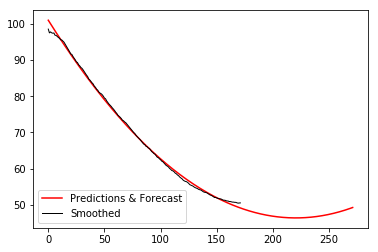

In [17]:
fig3 = pyplot.figure();
ax = fig3.add_subplot(111);
ax.plot(df3.index,df3['predictions_poly'], color = (1,0,0), label = 'Predictions & Forecast');
ax.plot(df3.index,df3['rolling_mean'], color = (0,0,0), linewidth = 1, label = 'Smoothed');
ax.legend(loc='lower left');